## Estimation Example



In this document we&rsquo;ll work through a simple approach to estimating
Constant Frisch Elasticity (CFE) demand systems.

There are two prerequisites; the first is the `CFEDemands` python
module.  You may have this already, but if not it  can be installed with a simple:



In [1]:
!pip install -r requirements.txt

  Using cached cfedemands-0.6.4.dev0-py2.py3-none-any.whl.metadata (1.6 kB)
  Using cached ConsumerDemands-0.4.3.dev0-py2.py3-none-any.whl.metadata (1.2 kB)
  Using cached eep153_tools-0.12.4-py2.py3-none-any.whl.metadata (363 bytes)
  Using cached python_gnupg-0.5.4-py2.py3-none-any.whl.metadata (2.0 kB)
  Using cached gspread_pandas-3.3.0-py2.py3-none-any.whl.metadata (10 kB)
  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)
Using cached cfedemands-0.6.4.dev0-py2.py3-none-any.whl (45 kB)
Using cached ConsumerDemands-0.4.3.dev0-py2.py3-none-any.whl (12 kB)
Using cached eep153_tools-0.12.4-py2.py3-none-any.whl (4.9 kB)
Using cached python_gnupg-0.5.4-py2.py3-none-any.whl (21 kB)
Using cached gspread_pandas-3.3.0-py2.py3-none-any.whl (27 kB)
Using cached fsspec-2025.3.2-py3-none-any.whl (194 kB)
  Attempting uninstall: gspread_pandas
    Found existing installation: gspread-pandas 2.2.3
    Uninstalling gspread-pandas-2.2.3:
      Successfully uninstalled gspread-pandas-2

The second prerequisite is a dataset including detailed information on
household expenditures and characteristics.  The structure of that
dataset is detailed in the next section.



### Data



Consider the case in which the data are saved in a google sheet; we&rsquo;ll
turn data from these into `pandas` dataframes.
There are limits on the allowable size of google sheets (5 million
cells when I last checked), so if your dataset is larger than this you&rsquo;ll need some other
mechanism to get your data into such dataframes.  Even in this latter
case you&rsquo;ll want your dataframes to have a structure that matches the
description given below.



#### Structure of the Spreadsheet



An example spreadsheet with data for Uganda can be found at
[https://docs.google.com/spreadsheets/d/1yFWlP5N7Aowaj6t2roRSFFUC50aFD-RLBGfzGtqLl0w/](https://docs.google.com/spreadsheets/d/1yFWlP5N7Aowaj6t2roRSFFUC50aFD-RLBGfzGtqLl0w/)

This spreadsheet consists of several worksheets, labeled &ldquo;RDI&rdquo;, &ldquo;FCT&rdquo;,
&ldquo;Household Characteristics&rdquo;, and a series of different years of food expenditures and prices

Most worksheets have the initial three columns labeled &ldquo;i&rdquo;, &ldquo;t&rdquo;, and
&ldquo;m&rdquo;; together these identify an observation uniquely.  The column &ldquo;i&rdquo;
should include a household id; the column &ldquo;t&rdquo; should include an
indicator for the year or period (for those of you with
cross-sectional data these will all take a common value, e.g., 2019);
the column &ldquo;m&rdquo; should be an indicator of &ldquo;market&rdquo;, which may be a
region identifier, or may take a single value (e.g., &ldquo;Uganda&rdquo;).

The triple (i,t,m) will serve as the index of some constructed
dataframes.  It is important not to have **too** many different values
for &ldquo;m&rdquo; (unless you have lots of data and RAM to play with).

Beyond the first three columns, the &ldquo;Expenditures&rdquo; worksheet for a given year should have one index (or alternatively, one column) for each category of expenditures (e.g., &ldquo;Beans&rdquo;, &ldquo;Beef&rdquo;, &ldquo;Beer&rdquo;,&#x2026;).

Beyond the first three columns, the &ldquo;Household Characteristics&rdquo; should
have columns corresponding to different elements of the vector of
observable characteristics $z$.  If the data permit, I recommend
constructing observables that match what I have in these data:
namely numbers of different children by age and sex, along with the
logarithm of total household size (&ldquo;log HSize&rdquo;).



#### From Sheet to DataFrame to Regression Object



We begin by defining a dictionary that contains the spreadsheet key.
One is provided for the Ugandan example that I wish to work
through.



In [8]:
#Uganda_Data = '1yFWlP5N7Aowaj6t2roRSFFUC50aFD-RLBGfzGtqLl0w'
Senegal_Data = '1FrCW6vIbpHx9jDfo2tBugmkUn5XoO-j5vE2Z5dLgU0E'

With the spreadsheet defined , grab it and define a couple of
dataframes. (Sheets should be shared with `students@eep153.iam.gserviceaccount.com`):



In [9]:
import pandas as pd
import numpy as np
from eep153_tools.sheets import read_sheets

# Change 'Uganda_Data' to key of your own sheet in Sheets, above
x = read_sheets(Senegal_Data,sheet='Food Expenditures (2019)')
x = x.set_index(['i','t','m','j']).squeeze()

# Expenditures x may have duplicate columns
x = x.T.groupby(['i','t','m','j']).sum()
x = x.replace(0,np.nan) # Replace zeros with missing
x
#food_expenditures = pd.read_csv('Food_Expenditures_T(2019).csv')

i       t     m        j                                                                  
221     2019  dakar    Abats et tripes (foie, rognon, etc.)                                   2000.0
                       Ail                                                                     100.0
                       Arachides décortiquées ou pilées (noflaye)                              500.0
                       Aubergine, Courge/Courgette                                             100.0
                       Autre légumes frais n.d.a (y compris les fleurs blanches de bissap)      50.0
                                                                                               ...  
259812  2019  sedhiou  Soumbala (netetou)                                                       50.0
                       Sucre (poudre ou morceaux)                                              600.0
                       Thé                                                                     100.0


In [38]:
# Get HH characteristics...
z = read_sheets(Senegal_Data,sheet='Household Characteristics')

if 'm' not in z.columns:
    z['m'] = 1

z = z.set_index(['i','t','m'])
z.columns.name = 'k'

z = z.apply(lambda x: pd.to_numeric(x,errors='coerce'))
z

,,k,women,girls,boys,men,M 00-03,F 00-03,M 04-08,F 04-08,M 09-13,F 09-13,M 14-18,F 14-18,M 19-30,F 19-30,M 31-50,F 31-50,M 51+,F 51+,log HSize
i,t,m,,,,,,,,,,,,,,,,,,,
11011,2018,ziguinchor,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.000000
110110,2018,ziguinchor,1,1,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1.386294
110111,2018,ziguinchor,0,0,2,2,0,0,0,0,0,0,2,0,1,0,1,0,0,0,1.386294
110112,2018,ziguinchor,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0.693147
11012,2018,ziguinchor,2,4,2,2,0,0,0,1,1,1,1,2,1,1,0,1,1,0,2.302585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2985,2019,ziguinchor,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.000000
2986,2019,ziguinchor,5,5,1,1,0,0,0,2,1,0,0,4,0,3,0,1,1,0,2.484907
2987,2019,ziguinchor,1,0,2,4,0,0,1,0,1,0,0,0,3,0,0,1,1,0,1.945910


In [10]:
# Now prices
p = read_sheets(Senegal_Data,sheet='Food Prices (2019)').set_index(['t','m','j','u'])

# Compute medians of prices for particular time, place and unit
p = p.groupby(['t','m','j','u']).median()

# Just keep metric units
p = p.xs('Kg',level="u").squeeze().unstack('j')

# Drop prices for goods we don't have expenditures for
#p = p[x.index.levels[-1]].T
valid_foods = x.index.get_level_values('j').unique()

# Filter the price dataset to only include valid foods
p = p.loc[:, p.columns.isin(valid_foods)]
p

p.head()

j                 Abats et tripes (foie, rognon, etc.)     Ail  \
t    m                                                           
2019 SAINT-LOUIS                                3000.0  1000.0   
     dakar                                      2400.0  1000.0   
     diourbel                                   1600.0  1050.0   
     fatick                                     1200.0  1300.0   
     kaffrine                                   3000.0  1150.0   

j                 Arachide grillée  \
t    m                               
2019 SAINT-LOUIS               NaN   
     dakar                     NaN   
     diourbel                  NaN   
     fatick                  800.0   
     kaffrine                400.0   

j                 Arachides décortiquées ou pilées (noflaye)  \
t    m                                                         
2019 SAINT-LOUIS                                       600.0   
     dakar                                             800.0   
     diourbel                                          700.0   
     fatick                                            450.0   
     kaffrine                                          500.0   

j                 Arachides fraîches en coques  Arachides séchées en coques  \
t    m                                                                        
2019 SAINT-LOUIS                           NaN                          NaN   
     dakar                                 NaN                        700.0   
     diourbel                              NaN                          NaN   
     fatick                                NaN                       1000.0   
     kaffrine                              NaN                        300.0   

j                 Aubergine, Courge/Courgette  \
t    m                                          
2019 SAINT-LOUIS                        300.0   
     dakar                              300.0   
     diourbel                           350.0   
     fatick                             400.0   
     kaffrine                           500.0   

j                 Autre légumes frais n.d.a (y compris les fleurs blanches de bissap)  \
t    m                                                                                  
2019 SAINT-LOUIS                                              400.0                     
     dakar                                                    800.0                     
     diourbel                                                   NaN                     
     fatick                                                   125.0                     
     kaffrine                                                   NaN                     

j                 Autres agrumes  Autres condiments (poivre etc.)  ...  \
t    m                                                             ...   
2019 SAINT-LOUIS           900.0                           3000.0  ...   
     dakar                1000.0                           4000.0  ...   
     diourbel                NaN                           2000.0  ...   
     fatick                  NaN                            100.0  ...   
     kaffrine                NaN                              NaN  ...   

j                 Poisson frais yaboy ou obo (sardinelle)  \
t    m                                                      
2019 SAINT-LOUIS                                      NaN   
     dakar                                            NaN   
     diourbel                                         NaN   
     fatick                                         500.0   
     kaffrine                                       500.0   

j                 Feuilles de baobab (lalo)  Tomate séchée  \
t    m                                                       
2019 SAINT-LOUIS                        NaN            NaN   
     dakar                              NaN            NaN   
     diourbel                        3500.0          400.0   
     fatick                          1400.

In [11]:
# Household characteristics
d = read_sheets(Senegal_Data,sheet="Household Characteristics")
d.columns.name = 'k'

# Fill blanks with zeros
d = d.replace(np.nan,0)

# Take logs of expenditures; call this y
y = np.log(x)

d.set_index(['i','t','m'],inplace=True)

This gives a dataframe of household characteristics $d$ with a simple structure.



In [12]:
d.head()

,,k,women,girls,boys,men,Males 00-03,Females 00-03,Males 04-08,Females 04-08,Males 09-13,Females 09-13,Males 14-18,Females 14-18,Males 19-30,Females 19-30,Males 31-50,Females 31-50,Males 51-99,Females 51-99,log HSize
i,t,m,,,,,,,,,,,,,,,,,,,
11011,2018,ziguinchor,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.000000
110110,2018,ziguinchor,1,1,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1.386294
110111,2018,ziguinchor,0,0,2,2,0,0,0,0,0,0,2,0,1,0,1,0,0,0,1.386294
110112,2018,ziguinchor,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0.693147
11012,2018,ziguinchor,2,4,2,2,0,0,0,1,1,1,1,2,1,1,0,1,1,0,2.302585


Also a dataframe of log expenditures $y$ with a similarly simple
structure.  Note that any expenditures of zero are dropped and
replaced with a missing value indicator.



In [13]:
y.head()

i    t     m      j                                                                  
221  2019  dakar  Abats et tripes (foie, rognon, etc.)                                   7.600902
                  Ail                                                                    4.605170
                  Arachides décortiquées ou pilées (noflaye)                             6.214608
                  Aubergine, Courge/Courgette                                            4.605170
                  Autre légumes frais n.d.a (y compris les fleurs blanches de bissap)    3.912023
Name: Expenditure, dtype: float64

### Estimation



Let $y_{i}^j$ be log expenditures on food $j$ by household $i$ at a particular time.  We want to estimate a regression that takes the form
$$
      y^j_{i} = A^j(p) + \gamma_j'd_i + \beta_j w_i + \zeta^j_i.
$$
We have data on `y` (log expenditures) and `d` (household characteristics).  This leaves the rest of the elements for us to estimate.



#### Basic Estimation



Just one line to set up the regression:



In [15]:
from cfe import Regression

result = Regression(y=y,d=d)

And then one line to predict expenditures and estimate most of the things we need:



In [16]:
result.predicted_expenditures()

i       t     m        j                                                                  
221     2019  dakar    Ail                                                                     162.631405
                       Arachides décortiquées ou pilées (noflaye)                              371.838707
                       Aubergine, Courge/Courgette                                             123.066420
                       Autre légumes frais n.d.a (y compris les fleurs blanches de bissap)     166.746810
                       Autres condiments (poivre etc.)                                         148.382966
                                                                                                 ...     
259812  2019  sedhiou  Thé                                                                     145.420446
                       Tomate fraîche                                                          135.910504
                       Viande de b__uf                       

Now we can compare predicted log expenditures with actual:



<Axes: xlabel='yhat', ylabel='y'>

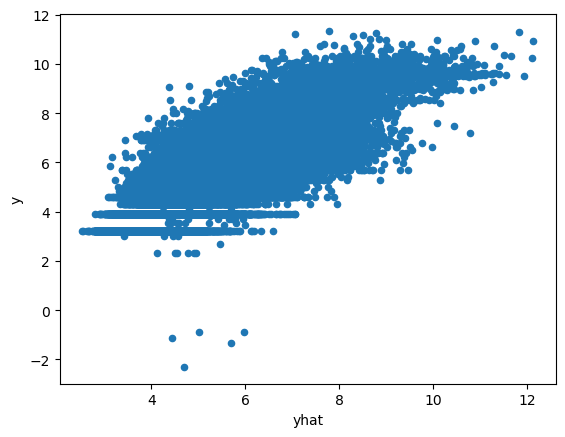

In [17]:
%matplotlib inline
df = pd.DataFrame({'y':y,'yhat':result.get_predicted_log_expenditures()})
df.plot.scatter(x='yhat',y='y')

That&rsquo;s all there is to estimation!  Note that we didn&rsquo;t estimate
demands for all goods&#x2014;lots of goods didn&rsquo;t have enough observations,
and were automatically dropped.



#### Parameters



##### (Relative) Income Elasticity



Some of the parameters have an interesting interpretation.  First among these are the $\beta$ coefficients, which govern how *income elastic* different goods are (higher values means more elastic).  These are also called *Frisch elasticities*.
Here we use a plot to visualize, with confidence intervals.



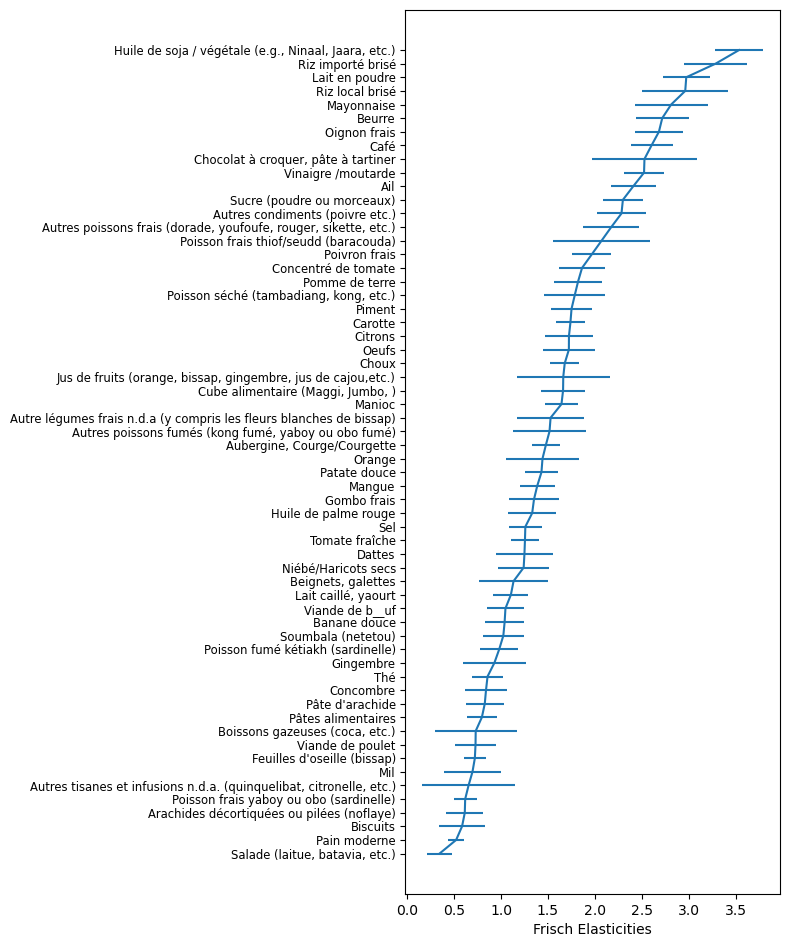

In [18]:
ax = result.graph_beta()

To just see the values of $\beta$:



In [19]:
result.get_beta()

j
Ail                                                                    2.408876
Arachides décortiquées ou pilées (noflaye)                             0.614182
Aubergine, Courge/Courgette                                            1.477778
Autre légumes frais n.d.a (y compris les fleurs blanches de bissap)    1.527870
Autres condiments (poivre etc.)                                        2.282984
Autres poissons frais (dorade, youfoufe, rouger, sikette, etc.)        2.173982
Autres poissons fumés (kong fumé, yaboy ou obo fumé)                   1.516480
Autres tisanes et infusions n.d.a. (quinquelibat, citronelle, etc.)    0.654187
Banane douce                                                           1.038459
Beignets, galettes                                                     1.133413
Beurre                                                                 2.716969
Biscuits                                                               0.585211
Boissons gazeuses (coca, etc.)        

In [20]:
result.to_pickle('./foo.pickle')

In [21]:
import cfe

result = cfe.read_pickle('foo.pickle')  # Get persistent result saved above...

xhat = result.predicted_expenditures()

# Expenditures divided by prices/kg gives quantities in kgs...
qhat = (xhat.unstack('j')/p).dropna(how='all')

# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

In [41]:
qhat.head()

,,j,Ail,Arachides décortiquées ou pilées (noflaye),"Aubergine, Courge/Courgette",Autre légumes frais n.d.a (y compris les fleurs blanches de bissap),Autres condiments (poivre etc.),"Autres poissons frais (dorade, youfoufe, rouger, sikette, etc.)","Autres poissons fumés (kong fumé, yaboy ou obo fumé)",Banane douce,"Beignets, galettes",Beurre,...,Pâtes alimentaires,Riz importé brisé,Riz local brisé,Sel,Soumbala (netetou),Sucre (poudre ou morceaux),Thé,Tomate fraîche,Viande de b__uf,Viande de poulet
i,t,m,,,,,,,,,,,,,,,,,,,,,
21741,2019,SAINT-LOUIS,0.032050,0.265591,0.222303,0.219141,0.013674,0.894645,0.111846,0.522606,NaN,NaN,...,0.656068,7.484873,26.854760,0.628580,NaN,0.711920,0.066328,0.455319,0.859548,2.622095
21742,2019,SAINT-LOUIS,0.035501,0.340397,0.258858,0.209256,0.015009,0.847975,0.088166,0.482351,NaN,NaN,...,0.822078,3.850091,33.433595,0.840241,NaN,0.866521,0.065812,0.482754,0.786354,2.396418
21743,2019,SAINT-LOUIS,0.031886,0.289306,0.250041,0.207237,0.012440,0.872988,0.159104,0.581761,NaN,NaN,...,0.955396,10.188992,27.905858,0.920277,NaN,0.821782,0.072776,0.519975,0.949144,2.815849
21744,2019,SAINT-LOUIS,0.054363,0.404498,0.324313,0.363885,0.024459,0.854793,0.116459,0.673300,NaN,NaN,...,0.793885,9.582238,55.881191,0.922162,NaN,1.282544,0.073551,0.588161,1.046022,3.572828
21745,2019,SAINT-LOUIS,0.040507,0.314111,0.263366,0.250037,0.014346,1.161211,0.243539,0.531484,NaN,NaN,...,0.859887,7.401768,30.538469,0.715907,NaN,0.975545,0.080655,0.533538,1.040405,2.897744


In [42]:
fct = read_sheets(Senegal_Data,sheet='FCT')
fct = fct.set_index('k')
fct = fct.drop('j', axis=1)
fct.columns.name = 'n'
fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))
fct.head()

n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
k,,,,,,,,,,,,,,,
Avocat,1600,20.0,70.0,810,120,85.0,6.0,17.38,1.30,0.67,70,0.0,2.57,100,6.0
Haricots (secs),1700,98.0,60.0,500,580,325.0,30.0,7.00,1.20,3.40,0,0.0,2.15,10,8.0
Haricots (frais),3470,214.0,160.0,5250,1130,626.0,51.0,11.74,2.12,7.13,0,0.0,4.74,63,23.0
Bœuf,2510,182.0,0.0,60,70,0.0,19.0,31.50,1.60,0.90,0,28.9,3.80,0,37.0
Bœuf (rôti),2910,264.0,0.0,70,90,0.0,27.0,37.20,2.20,0.90,0,24.7,3.40,0,60.0


In [43]:
rdi = read_sheets(Senegal_Data,sheet='RDI')
rdi = rdi.set_index('n')
rdi.columns.name = 'k'
rdi.head()

k,F 00-03,M 00-03,F 04-08,M 04-08,F 09-13,M 09-13,F 14-18,M 14-18,F 19-30,M 19-30,F 31-50,M 31-50,F 51+,M 51+
n,,,,,,,,,,,,,,
Energy,1000.0,1000.0,1200.0,1400.0,1600.0,1800.0,1800.0,2200.0,2000.0,2400.0,1800.0,2200.0,1600.0,2000.0
Protein,13.0,13.0,19.0,19.0,34.0,34.0,46.0,52.0,46.0,56.0,46.0,56.0,46.0,56.0
Fiber,14.0,14.0,16.8,19.6,22.4,25.2,25.2,30.8,28.0,33.6,25.2,30.8,22.4,28.0
Folate,150.0,150.0,200.0,200.0,300.0,300.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0
Calcium,700.0,700.0,1000.0,1000.0,1300.0,1300.0,1300.0,1300.0,1000.0,1000.0,1000.0,1000.0,1200.0,1000.0


In [29]:
use = fct.index.intersection(qhat.columns)


nutrients = qhat[use]@fct.loc[use,:]
nutrients.mean()    # NB: Nutrients are for past /week/ for entire household. (Depends on dataset)

n
Energy          38773.374934
Protein          1225.374101
Fiber             838.111013
Folate           8210.618832
Calcium          5715.170579
Carbohydrate     6800.260216
Iron              280.591817
Niacin            481.530747
Riboflavin         32.378194
Thiamin            39.512093
Vitamin A        1281.248197
Vitamin B-12       15.964398
Vitamin B-6        39.666762
Vitamin C         212.705282
Zinc              181.615716
dtype: float64

In [44]:
z = z[rdi.columns.tolist()]

hh_rdi = z@rdi.T

# Uganda data is per week, so make this a recommended WEEKLY intake:
hh_rwi = hh_rdi*7
hh_rwi.head()

,,n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Magnesium,Niacin,Phosphorus,Potassium,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Vitamin E,Vitamin K,Zinc
i,t,m,,,,,,,,,,,,,,,,,,,,
11011,2018,ziguinchor,14000.0,392.0,196.0,2800.0,7000.0,910.0,56.0,2940.0,112.0,4900.0,32900.0,9.1,8.4,6300.0,16.8,11.9,630.0,105.0,840.0,77.0
110110,2018,ziguinchor,54600.0,1274.0,764.4,10500.0,32200.0,3640.0,343.0,9240.0,392.0,27300.0,130200.0,30.1,29.4,20300.0,63.0,33.6,1925.0,392.0,2415.0,252.0
110111,2018,ziguinchor,63000.0,1512.0,882.0,11200.0,32200.0,3640.0,266.0,11480.0,448.0,27300.0,131600.0,36.4,33.6,25200.0,67.2,36.4,2310.0,420.0,2730.0,308.0
110112,2018,ziguinchor,23800.0,644.0,333.2,5600.0,17500.0,1820.0,161.0,4760.0,196.0,13650.0,65800.0,14.7,14.7,9800.0,33.6,18.9,980.0,210.0,1155.0,119.0
11012,2018,ziguinchor,130200.0,3045.0,1822.8,25200.0,80500.0,9100.0,833.0,22330.0,952.0,66850.0,319900.0,73.5,71.4,49700.0,151.2,83.3,4550.0,938.0,5740.0,616.0


In [46]:
# Match up nutrient names
use_nutrients = nutrients.columns.intersection(hh_rwi.columns)

nutrient_ratio = (nutrients[use_nutrients]/hh_rwi[use_nutrients]).dropna()

nutrient_ratio

,,n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
i,t,m,,,,,,,,,,,,,,,
221,2019,dakar,0.086831,0.133583,0.102563,0.079936,0.066799,0.162386,0.088054,0.143120,0.145551,0.121840,0.024031,0.099384,0.138184,0.052627,0.093685
222,2019,dakar,0.164124,0.298090,0.200814,0.169163,0.105447,0.270188,0.144613,0.288529,0.293939,0.254783,0.046179,0.191276,0.316299,0.113421,0.192697
223,2019,dakar,0.160743,0.237536,0.227838,0.161428,0.046562,0.335602,0.177627,0.289127,0.224392,0.253158,0.018473,0.070414,0.250794,0.055898,0.169091
224,2019,dakar,0.259851,0.416463,0.295373,0.237946,0.292477,0.562119,0.202767,0.410467,0.504018,0.387346,0.094254,0.375349,0.470477,0.163500,0.313918
226,2019,dakar,0.330964,0.553537,0.399473,0.302980,0.234531,0.595991,0.266954,0.543289,0.599382,0.493670,0.101416,0.378807,0.545271,0.199422,0.405302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259410,2019,sedhiou,2.703598,2.952806,4.269355,2.607658,0.563892,6.778389,4.508982,3.960378,3.403524,4.449527,0.175044,0.732278,3.073141,0.177340,2.378325
259612,2019,sedhiou,0.720847,1.089556,1.162476,0.855449,0.099792,1.521543,0.802014,1.281752,1.072954,1.420536,0.039219,0.157993,1.207095,0.048930,0.789595
259810,2019,sedhiou,2.132845,2.407845,3.460719,2.209549,0.327289,5.744097,2.365931,3.368894,2.698001,3.758831,0.080093,0.333982,2.740293,0.101592,1.955647


<Axes: >

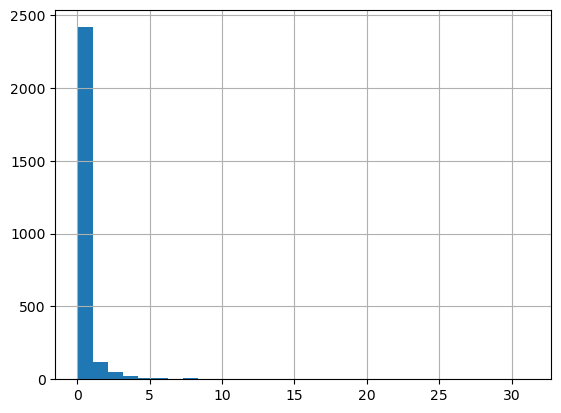

In [47]:
%matplotlib inline
nutrient_ratio['Energy'].hist(bins=30)

##### Demand and Household Composition



We&rsquo;re particularly interested in the effects of household composition on demand.  These are captured by the $\gamma_j$ parameters in the regression.



In [48]:
result.get_gamma()

k,women,girls,boys,men,Males 00-03,Females 00-03,Males 04-08,Females 04-08,Males 09-13,Females 09-13,Males 14-18,Females 14-18,Males 19-30,Females 19-30,Males 31-50,Females 31-50,Males 51-99,Females 51-99,log HSize,Constant
j,,,,,,,,,,,,,,,,,,,,
Ail,-0.221503,-0.351429,-0.102953,-0.009268,0.054733,0.339072,0.112565,0.336565,0.058519,0.317040,0.085952,0.301548,0.047503,0.292928,0.063172,0.336795,0.042637,0.280990,-0.068518,4.218342
Arachides décortiquées ou pilées (noflaye),0.019743,0.026205,0.013493,0.066193,0.046006,-0.012555,0.058560,0.007753,-0.043333,0.017106,0.038382,-0.034105,-0.024280,-0.005401,-0.020322,0.063950,-0.029618,0.014615,-0.087193,5.384355
"Aubergine, Courge/Courgette",0.258182,0.284657,-0.014124,0.079209,0.006750,-0.277432,0.052900,-0.267329,0.034523,-0.303113,0.009077,-0.314448,-0.052219,-0.201082,-0.051574,-0.199812,-0.004231,-0.225488,-0.003948,4.521483
Autre légumes frais n.d.a (y compris les fleurs blanches de bissap),0.312008,0.273223,-0.105467,0.179114,0.087348,-0.320090,0.064483,-0.368693,0.113360,-0.103613,-0.006351,-0.295637,-0.172043,-0.311049,-0.061957,-0.311769,0.051742,-0.355628,-0.021036,4.377144
Autres condiments (poivre etc.),1.695822,1.725458,-1.053130,-0.924607,1.051533,-1.774765,1.097141,-1.786097,0.991409,-1.760557,1.052339,-1.725689,0.893682,-1.610190,0.951743,-1.548623,0.961717,-1.569554,-0.061958,4.086618
"Autres poissons frais (dorade, youfoufe, rouger, sikette, etc.)",-0.719349,-0.827466,-0.068478,0.032993,-0.013699,0.813367,-0.053056,0.737139,0.039843,0.755797,-0.008392,0.771778,-0.063777,0.735905,0.061591,0.863508,0.006597,0.914888,0.006251,6.848774
"Autres poissons fumés (kong fumé, yaboy ou obo fumé)",-0.208050,0.231593,0.041529,0.059850,-0.204741,-0.290531,-0.069862,-0.361740,-0.121717,-0.130157,0.061668,-0.313409,0.040626,0.342258,0.176415,0.412618,0.222806,0.370229,-0.361010,5.692481
"Autres tisanes et infusions n.d.a. (quinquelibat, citronelle, etc.)",0.094377,-0.036520,-0.042157,0.118430,0.099802,0.072640,0.028063,0.023525,0.022293,0.170571,0.051231,-0.074159,-0.076340,-0.009684,-0.128602,-0.041100,0.083003,-0.079171,-0.351827,4.738751
Banane douce,0.076256,-0.075417,-0.093676,0.139767,0.034542,0.095381,0.110644,0.053616,0.154917,0.037331,0.087125,0.123115,-0.186483,-0.052699,-0.158833,-0.123773,0.008264,-0.126003,0.101065,6.092905


##### Welfare



Another import quantity we estimate is $w_i$.  This is a welfare measure for the household.  Here&rsquo;s a histogram:



<Axes: ylabel='Density'>

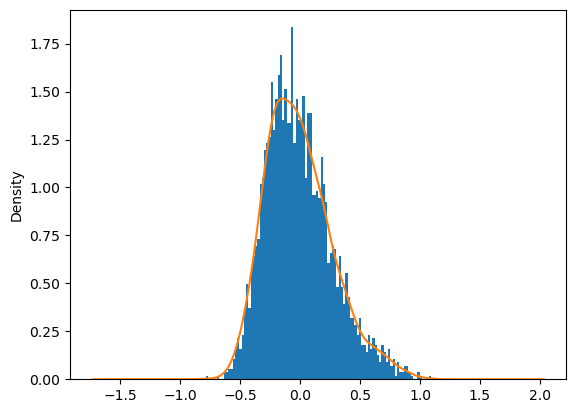

In [49]:
ax = result.get_w().plot.hist(bins=100,density=True)
result.get_w().plot.kde(ax=ax)

#### Saving Result



You can save the estimated result, using something like



In [51]:
result.to_pickle('senegal_estimates.rgsn')

You can subsequently load this using



In [52]:
import cfe
result = cfe.regression.read_pickle('senegal_estimates.rgsn')

#### Demand and Utility



Having estimated the demand system, we can examine the implied demand curves.



##### Budgets



Get food budget for all households, then find median budget:



In [53]:
import numpy as np

xhat = result.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median

##### Reference Prices



Choose reference prices.  Here we&rsquo;ll choose a particular year, and average prices across markets.  If you wanted to focus on particular market you&rsquo;d do this differently.



In [54]:
# Reference prices chosen from a particular time; average across place.
# These are prices per kilogram:
pbar = p.mean(axis=1)
#pbar = pbar[result.beta.index] # Only use prices for goods we can estimate

# Get the list of food items (j) from expenditures data
valid_foods = x.index.get_level_values('j').unique()

# Filter the price dataset to only include valid foods
p_filtered = p.loc[:, p.columns.isin(valid_foods)]

# Compute mean prices only for the valid goods
pbar = p_filtered.mean(axis=1)

# Replace missing prices with 1 (this is because they're best measured in expenditures)
pbar = pbar.replace(np.nan,1)

#Finally, define a function to change a single price in the vector $p$:
def my_prices(p0,j,p=pbar):
    """
    Change price of jth good to p0, holding other prices fixed.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

##### Demand as a function of prices



Let&rsquo;s take a look at demand schedules for households with different budgets.



In [55]:
pbar.head()

t     m          
2019  SAINT-LOUIS    1094.512649
      dakar          1461.388889
      diourbel       1611.496914
      fatick         1041.465054
      kaffrine       1019.038462
dtype: float64

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline

use = 'dakar'  # Good we want demand curve for

# Vary prices from 50% to 200% of reference.
scale = np.linspace(.5,2,20)

# Demand for Millet for household at median budget
plt.plot([result.demands(xref,my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 25% percentile
plt.plot([result.demands(xbar.quantile(0.25),my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 75% percentile
plt.plot([result.demands(xbar.quantile(0.75),my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.xlabel(f"Quantities of {use} Demanded")

KeyError: 'dakar'

##### Engel Curves



Engel curves trace out how demand changes with budget:



IndexError: index 14 is out of bounds for axis 0 with size 14

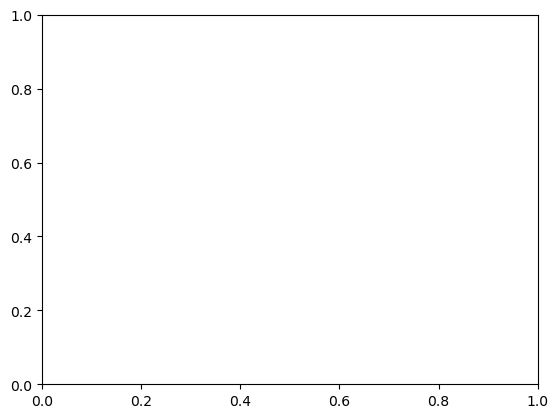

In [57]:
fig,ax = plt.subplots()

ax.plot(np.log(scale*xref),[result.expenditures(s*xref,pbar)/(s*xref) for s in scale])
ax.set_xlabel(f'log budget (relative to base of {xref:.0f}')
ax.set_ylabel(f'Expenditure share')
ax.set_title('Engel Curves')

##### Indirect Utility



We can also describe an indirect utility function that corresponds to these demands:



IndexError: index 14 is out of bounds for axis 0 with size 14

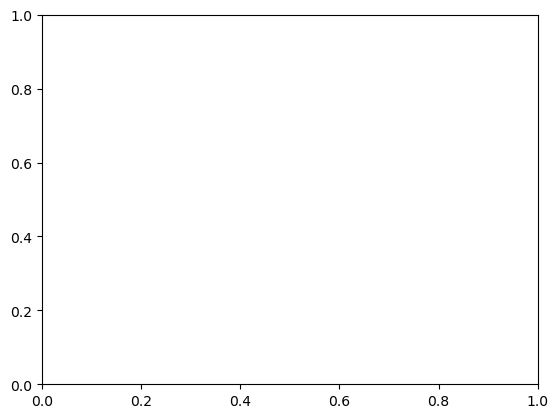

In [58]:
fig,ax = plt.subplots()

ax.plot(scale*xref,[result.indirect_utility(s*xref,pbar) for s in scale])
ax.set_xlabel(f'Indirect Utility (Budget relative to base of {xref:.0f}')
ax.set_ylabel(f'Utility')
ax.set_title('Indirect Utility Function')